In [1]:
import numpy as np
from lib import Experiments
from scipy.special import expit
import cvxpy as cp

from resource import getrusage as resource_usage, RUSAGE_SELF
from time import time as timestamp

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def load_image(filename, basewidth):
        img = Image.open(filename)
        wpercent = (basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img = img.resize((basewidth, hsize), Image.ANTIALIAS)
        return np.asarray(img, dtype="int32")

def load_data(img1_path='1.png', img2_path='2.png', show=False, size=10):
        img_s = []
        img_s.append((Experiments.load_image(img1_path, size)[:, :, 1],
                      Experiments.load_image(img2_path, size)[:, :, 1]))
        for i in range(2, 5+1):
            img_s.append((np.repeat(np.repeat(np.array(img_s[0][0]), i, axis=1), i, axis=0) + 1,
                          np.repeat(np.repeat(np.array(img_s[0][1]), i, axis=1), i, axis=0) + 1))

        C_s = []
        for k in range(5):
            C_s.append(np.zeros((img_s[k][0].shape[0] * img_s[k][0].shape[1], img_s[k][0].shape[0] * img_s[k][0].shape[1]), 
                                dtype=np.float128))
            for i in range(img_s[k][0].shape[0] * img_s[k][0].shape[1]):
                for j in range(img_s[k][0].shape[0] * img_s[k][0].shape[1]):
                    C_s[k][i, j] = np.linalg.norm(
                        np.array([i // img_s[k][0].shape[0], i % img_s[k][0].shape[1]]) - 
                        np.array([j // img_s[k][0].shape[0], j % img_s[k][0].shape[1]]), 2)
        
        p_s = []
        q_s = []
        for k in range(5):
            p_s.append(np.array(img_s[k][0].reshape((img_s[k][0].shape[0] * img_s[k][0].shape[1], )) / np.sum(img_s[k][0]), dtype=np.float128))
            q_s.append(np.array(img_s[k][1].reshape((img_s[k][1].shape[0] * img_s[k][1].shape[1], )) / np.sum(img_s[k][1]), dtype=np.float128))

        if show:
            plt.figure()
            plt.subplot(121)
            plt.imshow(img_s[0][0], cmap='gray')
            plt.subplot(122)
            plt.imshow(img_s[0][1], cmap='gray')
            plt.show()
            
            plt.figure()
            plt.subplot(121)
            plt.imshow(img_s[2][0], cmap='gray')
            plt.subplot(122)
            plt.imshow(img_s[2][1], cmap='gray')
            plt.show()
        return C_s, p_s, q_s

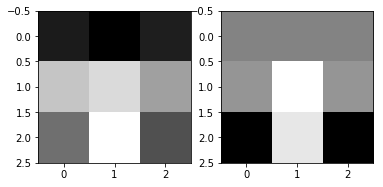

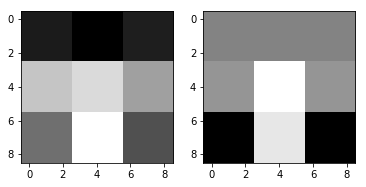

In [3]:
c_s, p_s, q_s = load_data('experiments/test_data/3.png', 'experiments/test_data/4.png', show=True, size=3)

In [4]:
x_stars = []
for k in range(len(p_s)):
    x = cp.Variable((p_s[k].shape[0], p_s[k].shape[0]))
    objective = cp.Minimize(cp.sum(cp.multiply(c_s[k], x)))
    constraints = [
        x >= 0,
        cp.sum(x) == 1,
        cp.sum(x, axis=1) == p_s[k],
        cp.sum(x, axis=0) == q_s[k]
    ]
    prob = cp.Problem(objective, constraints)

    result = prob.solve(solver=(cp.CPLEX if k == 0 else cp.SCS))
    x_stars.append(x.value)
    print("n = %i: sum(C * x_star) = %0.2f" % (k, np.sum(c_s[k]*x.value)))

n = 0: sum(C * x_star) = 0.13
n = 1: sum(C * x_star) = 0.26
n = 2: sum(C * x_star) = 0.39
n = 3: sum(C * x_star) = 0.51
n = 4: sum(C * x_star) = 0.64


In [5]:
class SinkhornMethod:
    def __init__(self, gamma, n=5, epsilon=0.001, epsilon_prox=0.001, log=False, prox=True):
        """
        Sinkhorn Method for Optimal Transport
        :param gamma: regularizer multiplier
        :param dim: transport vector dimension
        :param epsilon: desired accuracy
        """
        # dual func variables for indicator functions
        self.lambda_ = np.zeros(n, dtype=np.float128)
        self.my = np.zeros(n, dtype=np.float128)
        
        # constants
        self.gamma = gamma
        self.n = n
        self.epsilon = epsilon
        self.epsilon_prox = epsilon_prox
        
        self.prox = prox
        self.log = log
        if self.log:
            print("–––––––––––––––––––––––––––––")
            print("Algorithm configuration:")
            print("gamma = " + str(gamma))
            print("eps = " + str(epsilon))
            print("eps prox = " + str(self.epsilon_prox))
            print("–––––––––––––––––––––––––––––\n")
    
    
    def _new_dual_variables(self, C, p, q, xk):
        """
        Calculates Lagrange equation variables
        """
        self.lambda_ = self.gamma * np.log(1/p * np.sum([xk.T[j] * np.exp(-(self.gamma + C.T[j] + self.my[j])/self.gamma) for j in range(self.n)], 0))
        self.my = self.gamma * np.log(1/q * np.sum([xk[i] * np.exp(-(self.gamma + C[i] + self.lambda_[i])/self.gamma) for i in range(self.n)], 0))
    
    
    def _new_x(self, C, p, q, xk):
        return xk * np.exp(-(self.gamma + C + np.tile(self.lambda_, (self.n, 1)).T + np.tile(self.my, (self.n, 1)))/self.gamma)
    
    
    def _new_phi(self, C, p, q, xk):
        exp_ = -(C + np.tile(self.lambda_, (self.n, 1)).T + np.tile(self.my, (self.n, 1)) + self.gamma ) / self.gamma
        return - np.sum(self.lambda_ * p) - np.sum(self.my * q) - self.gamma * np.sum(xk * expit(exp_))
    
    
    def _new_f(self, C, x, xk):
        return np.sum(C * x) + self.gamma * np.sum((x + 1e-16) * np.log((x + 1e-16) / xk))
    
    
    def ROUND(self, x, p, q):
        F = x
        X = np.diag(np.minimum(p / F.sum(1), 1))
        F_ = X @ F
        Y = np.diag(np.minimum(q / F_.sum(0), 1))
        F__ = F_ @ Y
        err_p = p - F__.sum(1); err_q = q - F__.sum(0)
        G = F__ + err_p @ err_q.T / np.linalg.norm(err_p, 1)
        return G
            
        
    def fit(self, C, p, q, x_star, gamma_choosing=False):
        if not gamma_choosing:
            self.gamma = self.epsilon / (4 * np.log10(self.n))
        
        self.epsilon_ = self.epsilon / (8 * np.max(C))
        xk = 1/self.n**2 * np.ones((self.n, self.n))
        t = 0
        while True:
            self._new_dual_variables(C, p, q, xk)
            x = self._new_x(C, p, q, xk)
            t += 1
            
            if self.log and t % 500 == 0:
                print("Inner iteration " + str(t) + ":", "metric = " + str(round(np.abs(p - x.sum(1)).sum() + np.abs(q - x.sum(0)).sum(), 20)), "> " + str(round(self.epsilon_, 5)))
            
            if np.abs(p - x.sum(1)).sum() + np.abs(q - x.sum(0)).sum() <= self.epsilon_:
                break
        return x, t, 1, np.sum(C * (x - x_star))
    
    
    def fit_prox(self, C, p, q, x_star):
        t = 0
        k = 0
        inner_it = []
        self.epsilon_ = self.epsilon_prox / (8 * np.max(C))
        x = 1/self.n**2 * np.ones((self.n, self.n))
        while True:
            xk = x.copy()
            
            it = 0
            while True:
                self._new_dual_variables(C, p, q, xk)
                t += 1
                it += 1
                
                c = 1 / (2 * self.n) * (np.sum(self.my) - np.sum(self.lambda_))
                self.lambda_ += c
                self.my -= c
                x = self._new_x(C, p, q, xk)
                
                if self.log and t % 1000 == 0:
                    print("Inner iteration " + str(t) + ":", "metric = " + str(np.abs(p - x.sum(1)).sum() + np.abs(q - x.sum(0)).sum()), "> " + str(self.epsilon_))
                
                if np.abs(p - x.sum(1)).sum() + np.abs(q - x.sum(0)).sum() <= self.epsilon_:
                    break
            inner_it.append(it)
            
            x = self.ROUND(x, p, q)
            k += 1
            
            if self.log and k % 1 == 0:
                print("– Outer iteration " + str(k) + ":", "metric = " + str(np.sum(C * (x - x_star))), "> " + str(self.epsilon))
            
            if (np.sum(C * (x - x_star)) <= self.epsilon):
                return x, t, k, inner_it

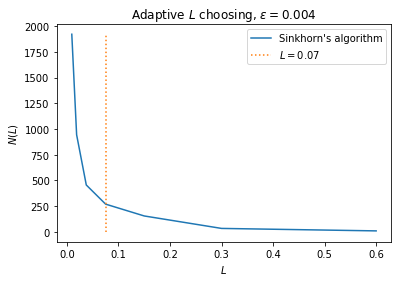

In [7]:
plot_data_x = []
plot_data = []

k_0 = None
L_0 = 0.6
adaptive_L = None
for i in range(7):
    x, k, t, d = SinkhornMethod(gamma=L_0 / 2**i, epsilon=2**(-8), log=False, n=p_s[0].shape[0]).fit(c_s[0], p_s[0], q_s[0], x_stars[0], gamma_choosing=True)
    if i == 0: k_0 = k
    plot_data_x.append(L_0 / 2**i)
    plot_data.append(k)    
    
    if k / k_0 > 20:
        k_0 = 1e+9
        adaptive_L = L_0 / 2**i


plt.title("Adaptive $L$ choosing, $\epsilon = 0.004$")
plt.xlabel("$L$")
plt.ylabel("$N(L)$")

plt.plot(plot_data_x, plot_data, label="Sinkhorn's algorithm")
plt.plot([adaptive_L, adaptive_L], [0, np.max(plot_data)], ':', label="$L = %0.2f$" % adaptive_L)

plt.legend()
plt.show()

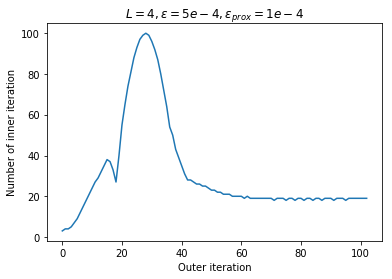

In [8]:
x, k, t, mean_it = SinkhornMethod(gamma=4, epsilon=2**(-10), epsilon_prox=1e-4, log=False, n=p_s[0].shape[0]).fit_prox(c_s[0], p_s[0], q_s[0], x_stars[0])

plt.title("$L=4, \epsilon=5e-4, \epsilon_{prox}=1e-4$")
plt.xlabel("Outer iteration")
plt.ylabel("Number of inner iteration")

plt.plot(mean_it)

plt.show()

In [23]:
def working_time(function, c, p, q, x_star, eps=2**(-6), mean_iter=False):
    start_time, start_resources = timestamp(), resource_usage(RUSAGE_SELF)
    if function == "Sinkhorn":
        x, mean_it, t, err = SinkhornMethod(gamma=None, epsilon=eps, log=False, n=p.shape[0]).fit(c, p, q, x_star)
        k = mean_it
    elif function == "Sinkhorn Prox":
        x, k, t, mean_it = SinkhornMethod(gamma=1, epsilon=eps, epsilon_prox=1e-4, log=False, n=p.shape[0]).fit_prox(c, p, q, x_star)
    elif function == "Sinkhorn Prox 2":
        x, k, t, mean_it = SinkhornMethod(gamma=10, epsilon=eps, epsilon_prox=1e-4, log=False, n=p.shape[0]).fit_prox(c, p, q, x_star)
    end_resources, end_time = resource_usage(RUSAGE_SELF), timestamp()

    return np.array([(end_resources.ru_stime - start_resources.ru_stime)*1e+3, int(np.mean(mean_it)) if mean_iter else int(k)])

In [50]:
epss = []
for i in range(1, 10):
    epss.append(2**(-i))

nss = np.array([p_s[0].shape[0], p_s[1].shape[0], p_s[2].shape[0], p_s[3].shape[0]])

In [51]:
# Experiments for different epsilon
# Sinkhorn's algorithm

sinkhorn_epss_time = []
sinkhorn_epss_iter = []

for eps in epss:
    data = working_time("Sinkhorn", c_s[0], p_s[0], q_s[0], x_stars[0], eps=eps)
    print("eps = %0.2e: " % eps, "T = %2.2f" % data[0], "N = %i" % int(data[1]))
    sinkhorn_epss_time.append(data[0])
    sinkhorn_epss_iter.append(data[1])

eps = 5.00e-01:  T = 1.89 N = 37
eps = 2.50e-01:  T = 1.44 N = 121
eps = 1.25e-01:  T = 1.61 N = 332
eps = 6.25e-02:  T = 1.80 N = 888
eps = 3.12e-02:  T = 5.52 N = 2055
eps = 1.56e-02:  T = 6.21 N = 4329
eps = 7.81e-03:  T = 6.30 N = 8826
eps = 3.91e-03:  T = 16.64 N = 17771
eps = 1.95e-03:  T = 23.86 N = 35613


In [56]:
# Proximal Sinkhorn's algorithm, gamma = 1

prox1_epss_time = []
prox1_epss_iter = []

for eps in epss:
    data = working_time("Sinkhorn Prox", c_s[0], p_s[0], q_s[0], x_stars[0], eps=eps)
    print("eps = %0.2e: " % eps, "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox1_epss_time.append(data[0])
    prox1_epss_iter.append(data[1])

eps = 5.00e-01:  T = 1.94 N = 25
eps = 2.50e-01:  T = 1.02 N = 63
eps = 1.25e-01:  T = 1.45 N = 63
eps = 6.25e-02:  T = 0.70 N = 134
eps = 3.12e-02:  T = 1.04 N = 229
eps = 1.56e-02:  T = 2.72 N = 371
eps = 7.81e-03:  T = 1.08 N = 577
eps = 3.91e-03:  T = 2.26 N = 1227
eps = 1.95e-03:  T = 4.44 N = 2188


In [59]:
# Proximal Sinkhorn's algorithm, gamma = 10

prox10_epss_time = []
prox10_epss_iter = []

for eps in epss:
    data = working_time("Sinkhorn Prox 2", c_s[0], p_s[0], q_s[0], x_stars[0], eps=eps)
    print("eps = %0.2e: " % eps, "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox10_epss_time.append(data[0])
    prox10_epss_iter.append(data[1])

eps = 5.00e-01:  T = 2.70 N = 58
eps = 2.50e-01:  T = 1.63 N = 131
eps = 1.25e-01:  T = 1.23 N = 229
eps = 6.25e-02:  T = 2.50 N = 363
eps = 3.12e-02:  T = 0.89 N = 492
eps = 1.56e-02:  T = 3.19 N = 672
eps = 7.81e-03:  T = 3.33 N = 1211
eps = 3.91e-03:  T = 4.93 N = 1994
eps = 1.95e-03:  T = 5.16 N = 2531


In [60]:
epss = np.log(1/np.array(epss))

In [64]:
# Experiments for different n
# Sinkhorn's algorithm

sinkhorn_nss_time = []
sinkhorn_nss_iter = []

for i in range(nss.shape[0]):
    data = working_time("Sinkhorn", c_s[i], p_s[i], q_s[i], x_stars[i])    
    print("n = %i: " % nss[i], "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    sinkhorn_nss_time.append(data[0])
    sinkhorn_nss_iter.append(data[1])

n = 9:  T = 4.67 N = 4329
n = 36:  T = 37.32 N = 14943
n = 81:  T = 388.38 N = 25266
n = 144:  T = 4875.26 N = 69002


In [65]:
# Proximal Sinkhorn's algorithm, gamma = 1

prox1_nss_time = []
prox1_nss_iter = []

for i in range(nss.shape[0]):
    data = working_time("Sinkhorn Prox", c_s[i], p_s[i], q_s[i], x_stars[i])    
    print("n = %i: " % nss[i], "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox1_nss_time.append(data[0])
    prox1_nss_iter.append(data[1])

n = 9:  T = 3.05 N = 371
n = 36:  T = 2.28 N = 1242
n = 81:  T = 16.28 N = 2425
n = 144:  T = 208.84 N = 4383


In [66]:
# Proximal Sinkhorn's algorithm, gamma = 10

prox10_nss_time = []
prox10_nss_iter = []

for i in range(nss.shape[0]):
    data = working_time("Sinkhorn Prox 2", c_s[i], p_s[i], q_s[i], x_stars[i])    
    print("n = %i: " % nss[i], "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox10_nss_time.append(data[0])
    prox10_nss_iter.append(data[1])

n = 9:  T = 3.88 N = 672
n = 36:  T = 3.26 N = 2316
n = 81:  T = 89.89 N = 4175
n = 144:  T = 649.49 N = 6551


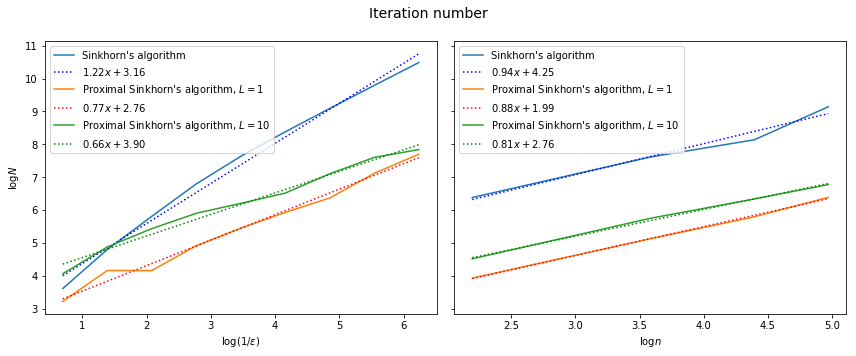

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

f.suptitle("Iteration number", fontsize=14)
ax1.set_title("\n")
ax1.set_xlabel("$\log (1/\\varepsilon)$")
ax1.set_ylabel("$\log N$")
ax1.plot(epss, np.log(np.array(sinkhorn_epss_iter)), label="Sinkhorn's algorithm")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(sinkhorn_epss_iter), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'b:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax1.plot(epss, np.log(np.array(prox1_epss_iter)), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox1_epss_iter), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'r:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax1.plot(epss, np.log(np.array(prox10_epss_iter)), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox10_epss_iter), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'g:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax1.legend()

ax2.set_title("\n")
ax2.set_xlabel("$\log n$")
ax2.plot(np.log(nss), np.log(np.array(sinkhorn_nss_iter)), label="Sinkhorn's algorithm")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log(np.array(sinkhorn_nss_iter)), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'b:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax2.plot(np.log(nss), np.log(np.array(prox1_nss_iter)), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log(np.array(prox1_nss_iter)), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'r:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax2.plot(np.log(nss), np.log(np.array(prox10_nss_iter)), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log(np.array(prox10_nss_iter)), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'g:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax2.legend()

plt.tight_layout()
plt.savefig("iterations.eps", dpi=400)
plt.show()

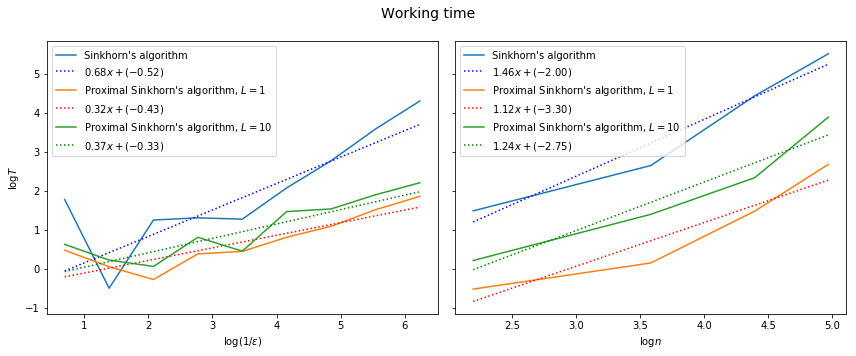

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

f.suptitle("Working time", fontsize=14)
ax1.set_title("\n")
ax1.set_xlabel("$\log (1/\\varepsilon)$")
ax1.set_ylabel("$\log T$")
ax1.plot(epss, np.log((1 * np.abs(polyval([*polyfit(epss, sinkhorn_epss_time, 2)], epss)) + sinkhorn_epss_time) / 2), label="Sinkhorn's algorithm")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(history), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'b:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax1.plot(epss, np.log((1 * np.abs(polyval([*polyfit(epss, prox1_epss_time, 2)], epss)) + prox1_epss_time) / 2), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox1_epss_time), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'r:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax1.plot(epss, np.log((1 * np.abs(polyval([*polyfit(epss, prox10_epss_time, 2)], epss)) + prox10_epss_time) / 2), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox10_epss_time), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'g:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax1.legend()

ax2.set_title("\n")
ax2.set_xlabel("$\log n$")
ax2.plot(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), sinkhorn_nss_time, 2)], np.log(nss))) + sinkhorn_nss_time) / 2), label="Sinkhorn's algorithm")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), sinkhorn_nss_time, 2)], np.log(nss))) + sinkhorn_nss_time) / 2), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'b:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax2.plot(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), prox1_nss_time, 2)], np.log(nss))) + prox1_nss_time) / 2), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), prox1_nss_time, 2)], np.log(nss))) + prox1_nss_time) / 2), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'r:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax2.plot(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), prox10_nss_time, 2)], np.log(nss))) + prox10_nss_time) / 2), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log((1 * np.abs(polyval([*polyfit(np.log(nss), prox10_nss_time, 2)], np.log(nss))) + prox10_nss_time) / 2), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'g:', label="$%.2f x + (%.2f)$" % (fp[0], fp[1]))
ax2.legend()

plt.tight_layout()
plt.show()

In [67]:
epss = []
for i in range(1, 9):
    epss.append(2**(-i))

In [70]:
# Mean experiments for different n
# Proximal Sinkhorn's algorithm, gamma = 1

prox1_epss_mean_iter = []

for eps in epss:
    data = working_time("Sinkhorn Prox", c_s[0], p_s[0], q_s[0], x_stars[0], eps=eps, mean_iter=True)
    print("eps = %0.2e: " % eps, "N_mean = %i" % int(data[1]))
    prox1_epss_mean_iter.append(data[1])

eps = 5.00e-01:  N_mean = 12
eps = 2.50e-01:  N_mean = 21
eps = 1.25e-01:  N_mean = 21
eps = 6.25e-02:  N_mean = 33
eps = 3.12e-02:  N_mean = 45
eps = 1.56e-02:  N_mean = 61
eps = 7.81e-03:  N_mean = 82
eps = 3.91e-03:  N_mean = 122


In [71]:
# Proximal Sinkhorn's algorithm, gamma = 10

prox10_epss_mean_iter = []

for eps in epss:
    data = working_time("Sinkhorn Prox 2", c_s[0], p_s[0], q_s[0], x_stars[0], eps=eps, mean_iter=True)
    print("eps = %0.2e: " % eps, "N_mean = %i" % int(data[1]))
    prox10_epss_mean_iter.append(data[1])

eps = 5.00e-01:  N_mean = 3
eps = 2.50e-01:  N_mean = 5
eps = 1.25e-01:  N_mean = 8
eps = 6.25e-02:  N_mean = 10
eps = 3.12e-02:  N_mean = 11
eps = 1.56e-02:  N_mean = 12
eps = 7.81e-03:  N_mean = 18
eps = 3.91e-03:  N_mean = 20


In [72]:
epss = np.log(1/np.array(epss))

In [73]:
# Experiments for different n
# Proximal Sinkhorn's algorithm, gamma = 1

prox1_nss_mean_iter = []

for i in range(nss.shape[0]):
    data = working_time("Sinkhorn Prox", c_s[i], p_s[i], q_s[i], x_stars[i], mean_iter=True)    
    print("n = %i: " % nss[i], "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox1_nss_mean_iter.append(data[1])

n = 9:  T = 3.96 N = 61
n = 36:  T = 2.07 N = 177
n = 81:  T = 60.66 N = 303
n = 144:  T = 285.08 N = 487


In [74]:
# Proximal Sinkhorn's algorithm, gamma = 10

prox10_nss_mean_iter = []

for i in range(nss.shape[0]):
    data = working_time("Sinkhorn Prox 2", c_s[i], p_s[i], q_s[i], x_stars[i], mean_iter=True)    
    print("n = %i: " % nss[i], "T = %0.2f" % data[0], "N = %i" % int(data[1]))
    prox10_nss_mean_iter.append(data[1])

n = 9:  T = 3.47 N = 12
n = 36:  T = 2.58 N = 36
n = 81:  T = 133.63 N = 55
n = 144:  T = 271.26 N = 77


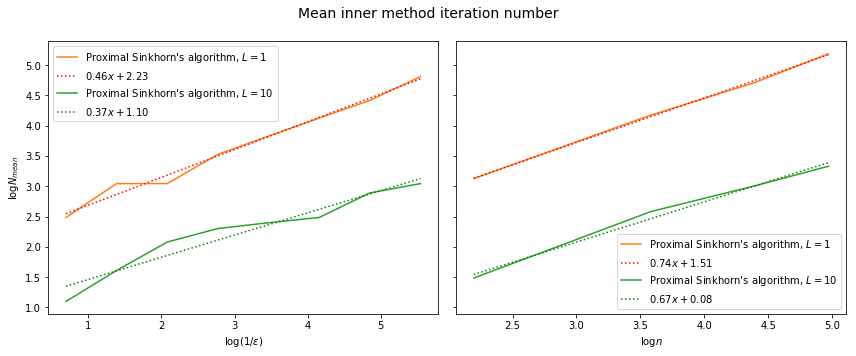

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,5))

f.suptitle("Mean inner method iteration number", fontsize=14)
ax1.set_title("\n")
ax1.set_xlabel("$\log (1/\\varepsilon)$")
ax1.set_ylabel("$\log N_{mean}$")
ax1.plot([], [])
ax1.plot(epss, np.log(np.array(prox1_epss_mean_iter)), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox1_epss_mean_iter), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'r:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax1.plot(epss, np.log(np.array(prox10_epss_mean_iter)), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(epss, np.log(prox10_epss_mean_iter), 1, full=True)
f = sp.poly1d(fp)
ax1.plot(epss, np.array(f(epss)), 'g:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax1.legend()

ax2.set_title("\n")
ax2.set_xlabel("$\log n$")
ax2.plot([], [])
ax2.plot(np.log(nss), np.log(np.array(prox1_nss_mean_iter)), label="Proximal Sinkhorn's algorithm, $L = 1$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log(np.array(prox1_nss_mean_iter)), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'r:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax2.plot(np.log(nss), np.log(np.array(prox10_nss_mean_iter)), label="Proximal Sinkhorn's algorithm, $L = 10$")
fp, residuals, rank, sv, rcond = sp.polyfit(np.log(nss), np.log(np.array(prox10_nss_mean_iter)), 1, full=True)
f = sp.poly1d(fp)
ax2.plot(np.log(nss), np.array(f(np.log(nss))), 'g:', label="$%.2f x + %.2f$" % (fp[0], fp[1]))
ax2.legend()

plt.tight_layout()
plt.show()